<a href="https://colab.research.google.com/github/DSI-Capstone-FS9/ABCD-MRI/blob/master/Explainability_CNN_T1_T2_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install tensorflow-gpu

import numpy as np
import pandas as pd
import warnings 
import nibabel as nib
import tensorflow as tf
import os
import math
import glob
import cv2

warnings.simplefilter('ignore')

In [2]:
tf.__version__

'2.0.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
t1_path = '/content/drive/My Drive/Capstone/05_Data/02_Sample_MRI/subsample/t1/'
t1_files = glob.glob(t1_path + '*.gz',recursive=True)
t1_all_files = sorted(t1_files)

t2_path = '/content/drive/My Drive/Capstone/05_Data/02_Sample_MRI/subsample/t2/'
t2_files = glob.glob(t2_path + '*.gz',recursive=True)
t2_all_files = sorted(t2_files)

In [0]:
t1 = pd.DataFrame([t1_all_files]).T
t1['label'] = 0
t1.columns = ['image','label']

t2 = pd.DataFrame([t2_all_files]).T
t2['label'] = 1
t2.columns = ['image','label']

df = pd.concat([t1,t2])

In [0]:
# dimensions to consider for the images
img_rows, img_cols, img_channels = 64,64,3

# batch size for training  
batch_size=1

# total number of classes in the dataset
nb_classes=2

In [0]:
def data_generator(data, 
                   batch_size,
                   preprocessing_fn = None,
                   is_validation_data=False):
    # Get total number of samples in the data
    n = len(data)
    nb_batches = int(np.ceil(n/batch_size))

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    while True:
        if not is_validation_data:
            # shuffle indices for the training data
            np.random.shuffle(indices)
            
        for i in range(nb_batches):
            # get the next batch 
            next_batch_indices = indices[i*batch_size:(i+1)*batch_size]
            nb_examples = len(next_batch_indices)
            
            # Define two numpy arrays for containing batch data and labels
            batch_data = np.zeros((nb_examples, 
                           img_rows, 
                           img_cols, 
                           img_channels), 
                          dtype=np.float32)
            batch_labels = np.zeros((nb_examples, nb_classes), dtype=np.float32)
            
            # process the next batch
            for j, idx in enumerate(next_batch_indices):
                #img = cv2.imread(data.iloc[idx]["image"])
                #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                img = nib.load(data.iloc[idx]["image"])
                img = np.array(img.dataobj)[:, :, 31:34]
                
                label = data.iloc[idx]["label"]
                
                #if not is_validation_data:
                    #img = seq.augment_image(img)
                
                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                batch_data[j] = img
                batch_labels[j] = to_categorical(label,num_classes=nb_classes)
            
            if preprocessing_fn is not None:
                batch_data = preprocessing_fn(batch_data)
            
            yield batch_data, batch_labels

In [0]:
#training data generator 
train_data_gen = data_generator(df, 
                                batch_size, 
                                preprocessing_fn=None)

# validation data generator 
valid_data_gen = data_generator(df, 
                                batch_size,
                                preprocessing_fn=None,
                                is_validation_data=True)

In [9]:
from skimage.io import imread, imsave
from skimage.transform import resize 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers as L
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K

import imgaug as ia
from imgaug import augmenters as iaa

def get_base_model():
    base_model = vgg16.VGG16(input_shape=(img_rows, img_cols, img_channels), 
                       weights=None, 
                       include_top=False)
    return base_model

# get the base model
base_model = get_base_model()

#  get the output of the second last dense layer 
base_model_output = base_model.layers[-2].output

# add new layers 
x = L.Dropout(0.5,name='drop2')(base_model_output)
output = L.Dense(nb_classes, activation='softmax', name='fc3')(x)
output = L.Flatten()(output)
output = L.Dense((2), activation='softmax', name='fc4')(output)

# define a new model 
model = Model(base_model.input, output)

# Freeze all the base model layers 
for layer in base_model.layers[:-1]:
    layer.trainable=False

# compile the model and check it 
optimizer = RMSprop(0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [0]:
# Use earlystopping 
es = EarlyStopping(patience=3, restore_best_weights=True)

# checkpoint to save model
chkpt = ModelCheckpoint(filepath="monkey_model.h5", save_best_only=True)

# number of training and validation steps for training and validation
nb_train_steps = int(np.ceil(len(df)/batch_size))
nb_valid_steps = int(np.ceil(len(df)/batch_size))

# number of epochs 
nb_epochs=10

In [11]:
# train the model 
history1 = model.fit_generator(train_data_gen, 
                              epochs=nb_epochs, 
                              steps_per_epoch=nb_train_steps, 
                              validation_data=valid_data_gen, 
                              validation_steps=nb_valid_steps,
                              callbacks=[es,chkpt])

Epoch 1/10
60/60 [==============================] - 9s 144ms/step - loss: 0.6938 - accuracy: 0.6167 - val_loss: 0.6230 - val_accuracy: 0.7000
Epoch 2/10
60/60 [==============================] - 7s 116ms/step - loss: 0.6301 - accuracy: 0.7000 - val_loss: 0.6033 - val_accuracy: 0.9167
Epoch 3/10
60/60 [==============================] - 7s 115ms/step - loss: 0.6241 - accuracy: 0.6833 - val_loss: 0.5900 - val_accuracy: 0.9500
Epoch 4/10
60/60 [==============================] - 7s 116ms/step - loss: 0.5946 - accuracy: 0.7333 - val_loss: 0.5801 - val_accuracy: 0.8833
Epoch 5/10
60/60 [==============================] - 7s 116ms/step - loss: 0.5940 - accuracy: 0.8500 - val_loss: 0.5739 - val_accuracy: 0.7500
Epoch 6/10
60/60 [==============================] - 7s 114ms/step - loss: 0.5699 - accuracy: 0.7667 - val_loss: 0.5560 - val_accuracy: 0.9667
Epoch 7/10
60/60 [==============================] - 7s 121ms/step - loss: 0.5869 - accuracy: 0.8333 - val_loss: 0.5393 - val_accuracy: 0.9833
Epoch 

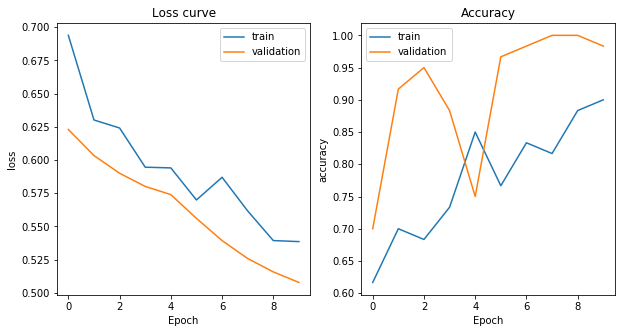

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# let's plot the loss and accuracy 

# get the training and validation accuracy from the history object
train_acc = history1.history['accuracy']
valid_acc = history1.history['val_accuracy']

# get the loss
train_loss = history1.history['loss']
valid_loss = history1.history['val_loss']

# get the number of entries
xvalues = np.arange(len(train_acc))

# visualize
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues, train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

In [13]:
# select all the layers for which you want to visualize the outputs and store it in a list
outputs = [layer.output for layer in model.layers[1:18]]

# Define a new model that generates the above output
vis_model = Model(model.input, outputs)

# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

Layers going to be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3']


In [0]:
def get_CAM(processed_image, predicted_label, layer_name='block5_conv3'):
    """
    This function is used to generate a heatmap for a sample image prediction.
    
    Args:
        processed_image: any sample image that has been pre-processed using the 
                       `preprocess_input()`method of a keras model
        predicted_label: label predicted by the network for this image
    
    Returns:
        heatmap: heatmap generated over the last convolution layer output 
    """
    
    # this will be the model that would give us the graidents
    model_grad = Model([model.inputs], 
                       [model.get_layer(layer_name).output, model.output])
    
    # Gradient tape gives you everything you need
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)
        loss = predictions[:, predicted_label]
    
    # get the gradients wrt to the chosen layer
    grads_values = tape.gradient(loss, conv_output_values)
    
    # take mean gradient per feature map
    grads_values = K.mean(grads_values, axis=(0,1,2))
    
    # convert to numpy. This is done just for image operations.
    # Check for shapes and you would understand why we performed 
    # the squeeze operation here.
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()
    
    
    # iterate over each feature map in yout conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    for i in range(512): # we have 512 features in our last conv layer
        conv_output_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_output_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
    
    return heatmap

In [0]:
def show_random_sample(idx):
    """
    This function is used to select a random sample from the validation dataframe.
    It generates prediction for the same. It also stores the heatmap and the intermediate
    layers activation maps.
    
    Arguments:
        idx: random index to select a sample from validation data
    
    Returns:
        activations: activation values for intermediate layers
    """
    # select the sample and read the corresponding image and label
    #sample_image = cv2.imread(valid_df.iloc[idx]['image'])
    #sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    
    sample_image = nib.load(df.iloc[idx]['image'])
    sample_image = np.array(sample_image.dataobj)[:, :, 33:36]
    #sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    
    sample_image = cv2.resize(sample_image, (img_rows, img_cols))
    sample_image = tf.cast(sample_image, tf.float32)
    sample_label = df.iloc[idx]["label"]
    
    # pre-process the image
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    #sample_image_processed = preprocessing_fn(sample_image_processed)
    
    # generate activation maps from the intermediate layers using the visualization model
    activations = vis_model.predict(sample_image_processed)
    
    # get the label predicted by our original model
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
    # choose any random activation map from the activation maps 
    sample_activation = activations[0][0,:,:,16]
    
    # normalize the sample activation map
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    # convert pixel values between 0-255
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    
    
    # get the heatmap for class activation map(CAM)
    heatmap = get_CAM(sample_image_processed, pred_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    super_imposed_image = heatmap * 0.5 + sample_image
    super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)

    f,ax = plt.subplots(2,2, figsize=(15,8))
    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.show()
    
    return activations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


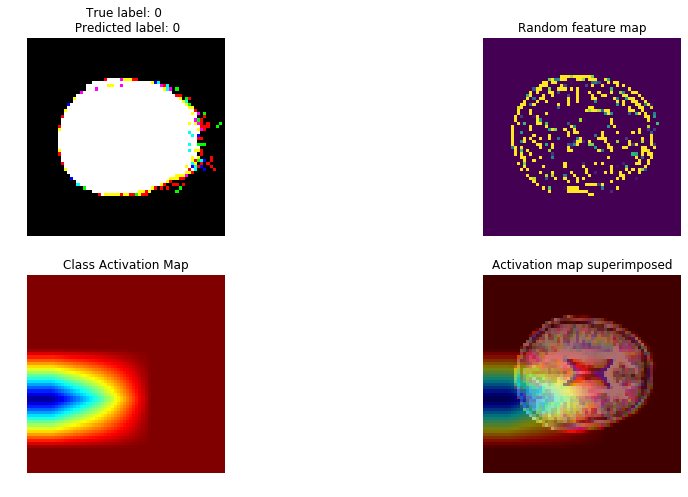

In [16]:
_ = show_random_sample(idx=1)

In [0]:
def visualize_intermediate_activations(layer_names, activations):
    """
    This function is used to visualize all the itermediate activation maps
    
    Arguments:
        layer_names: list of names of all the intermediate layers we chose
        activations: all the intermediate activation maps 
    """
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=16
    
    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size*nb_cols, size*images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[0,:,:,col*images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

        scale = 1./size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(grid, aspect='auto', cmap='viridis')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


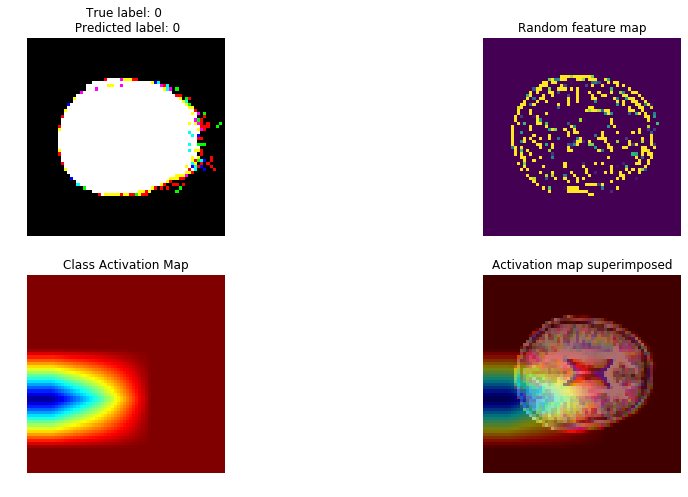

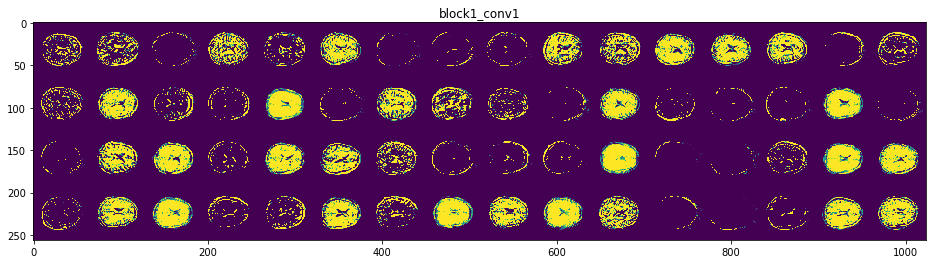

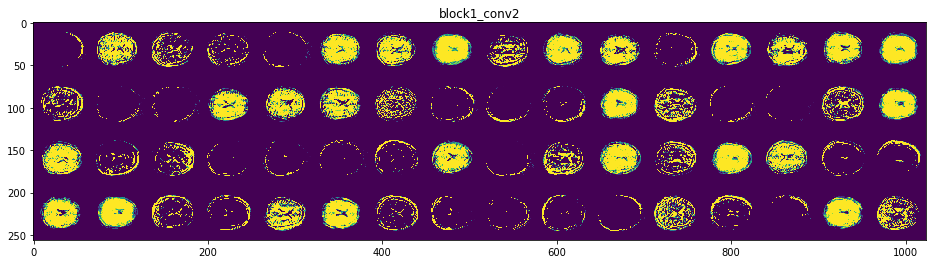

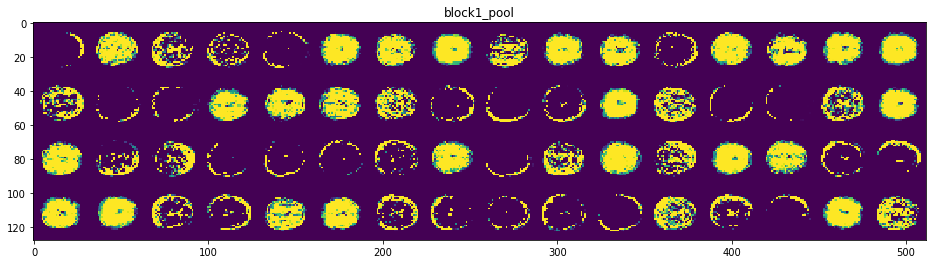

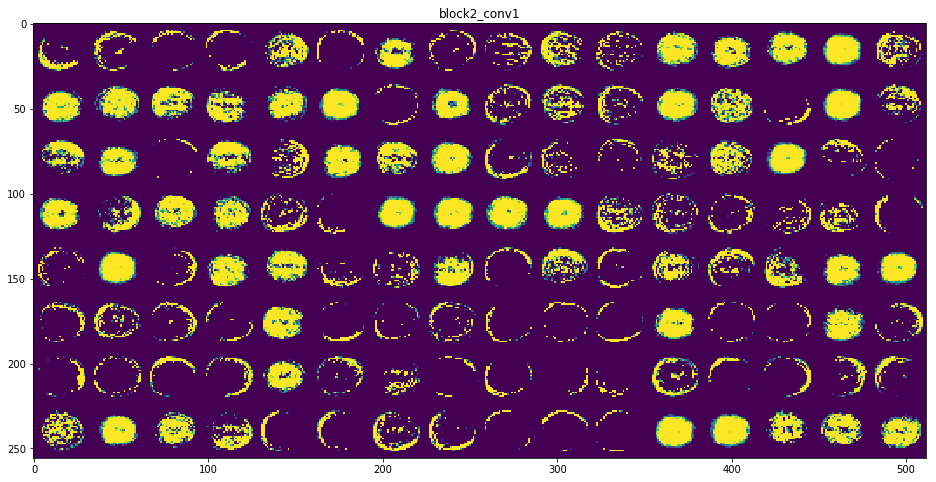

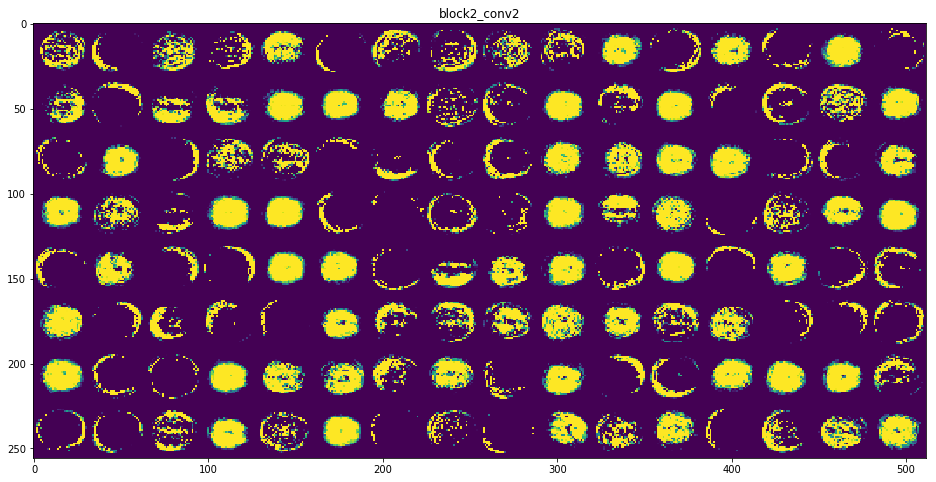

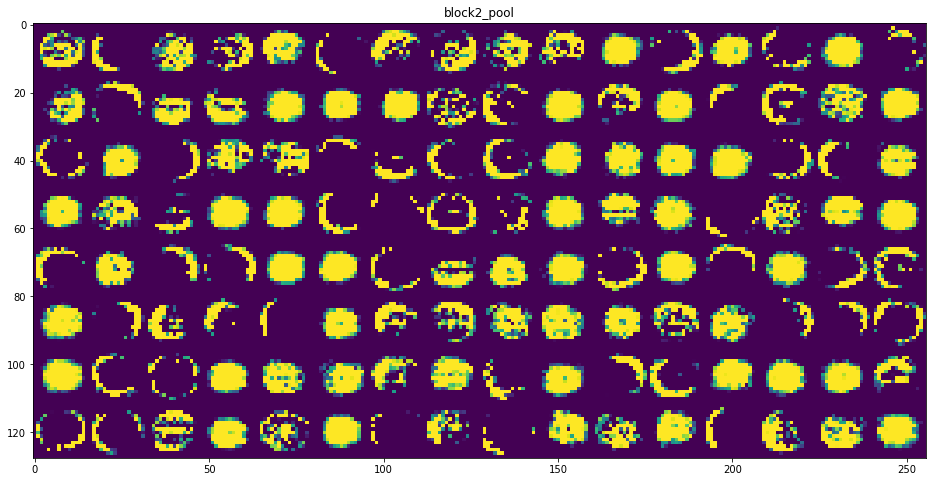

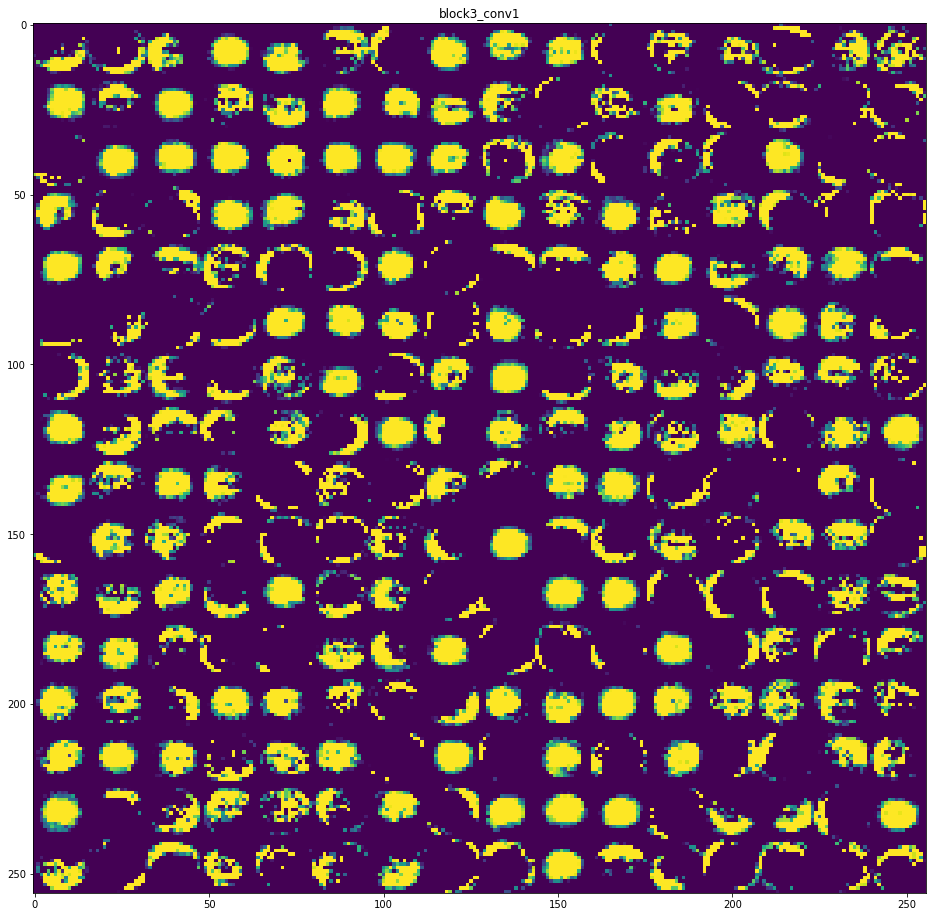

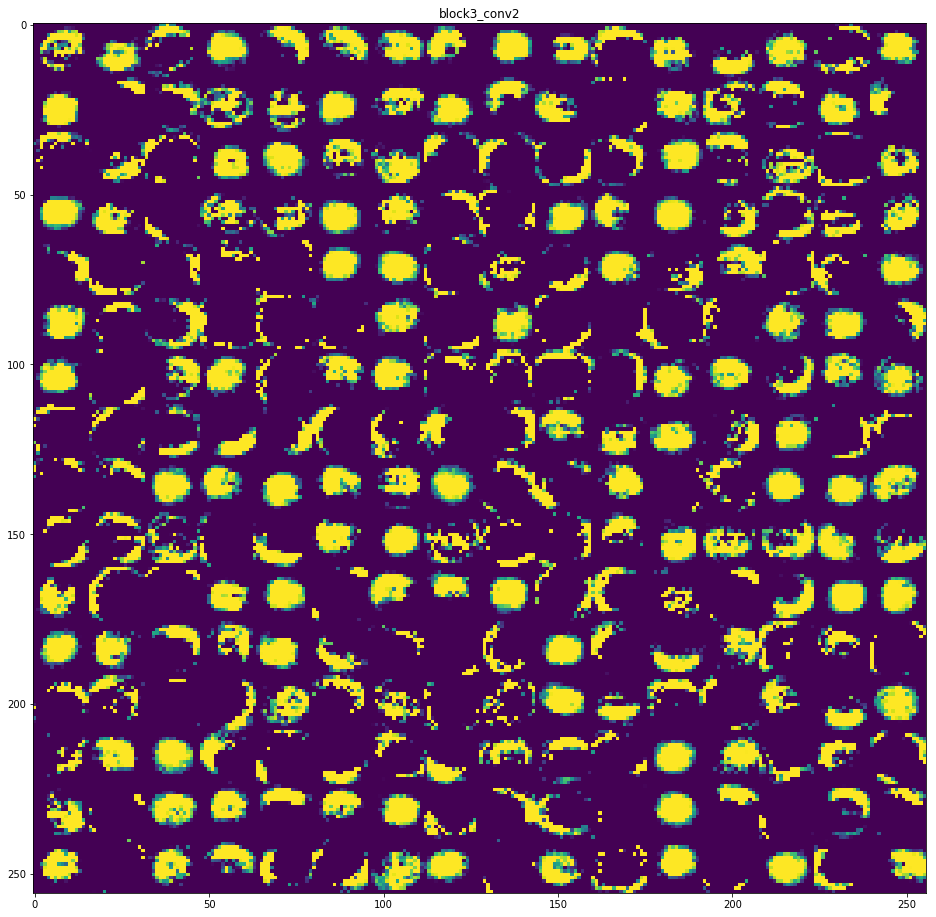

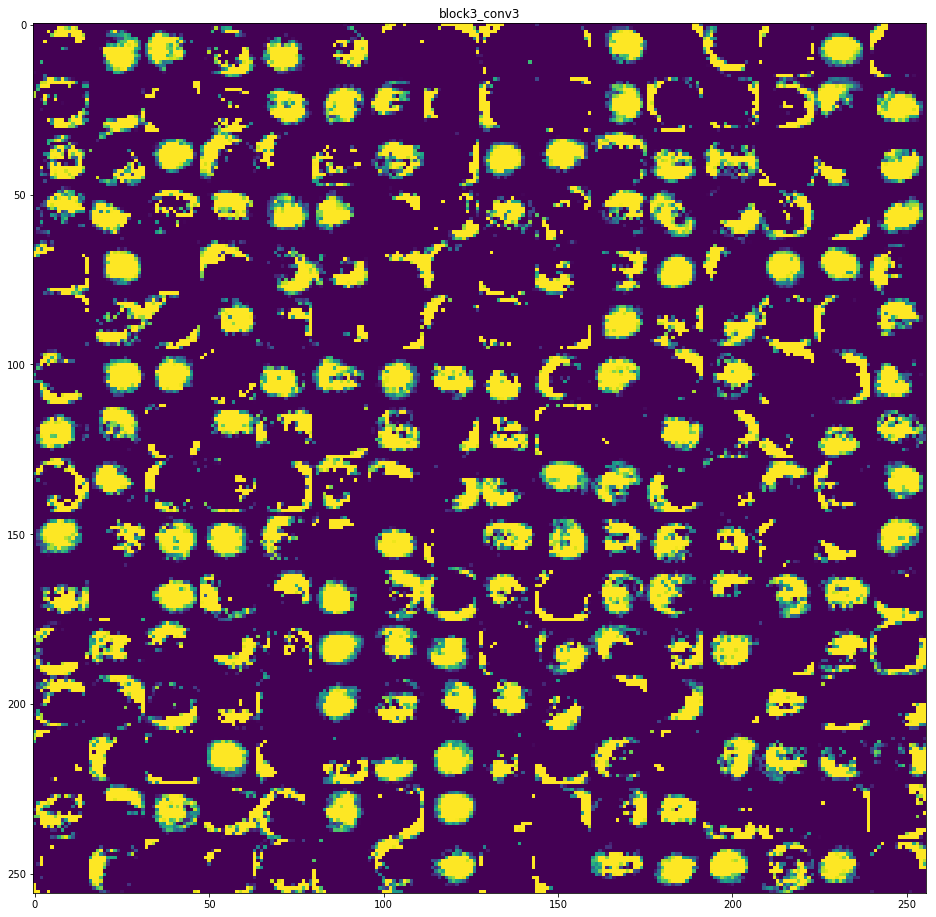

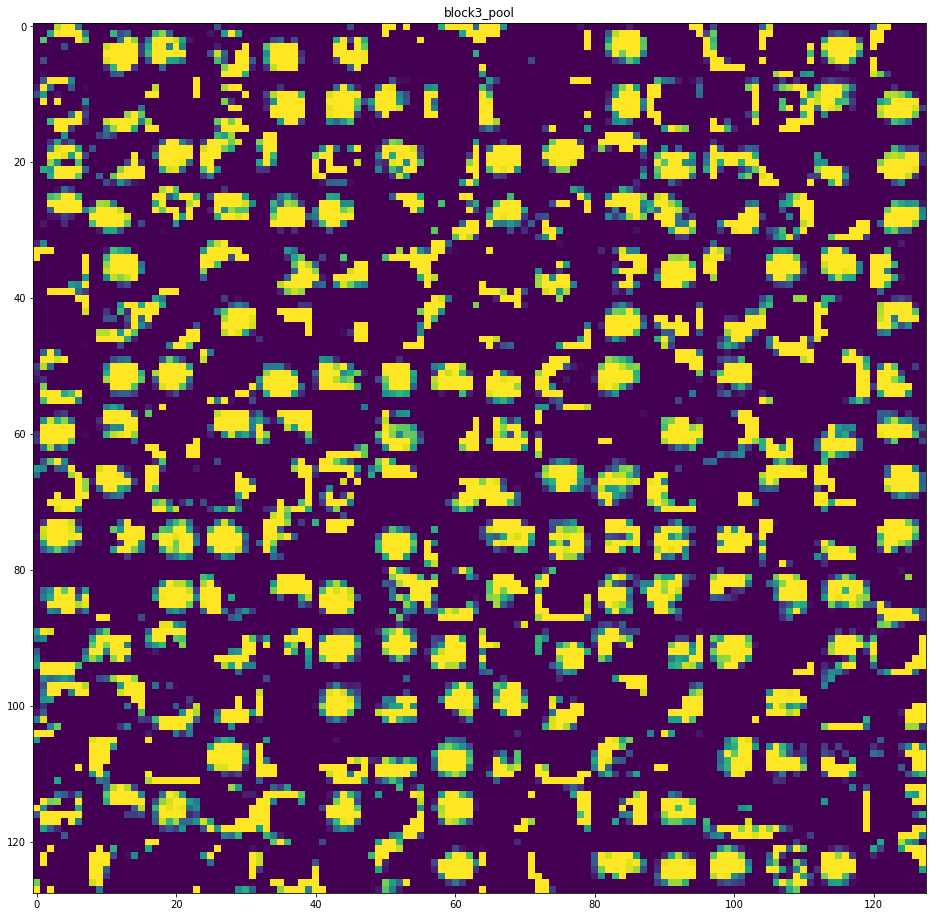

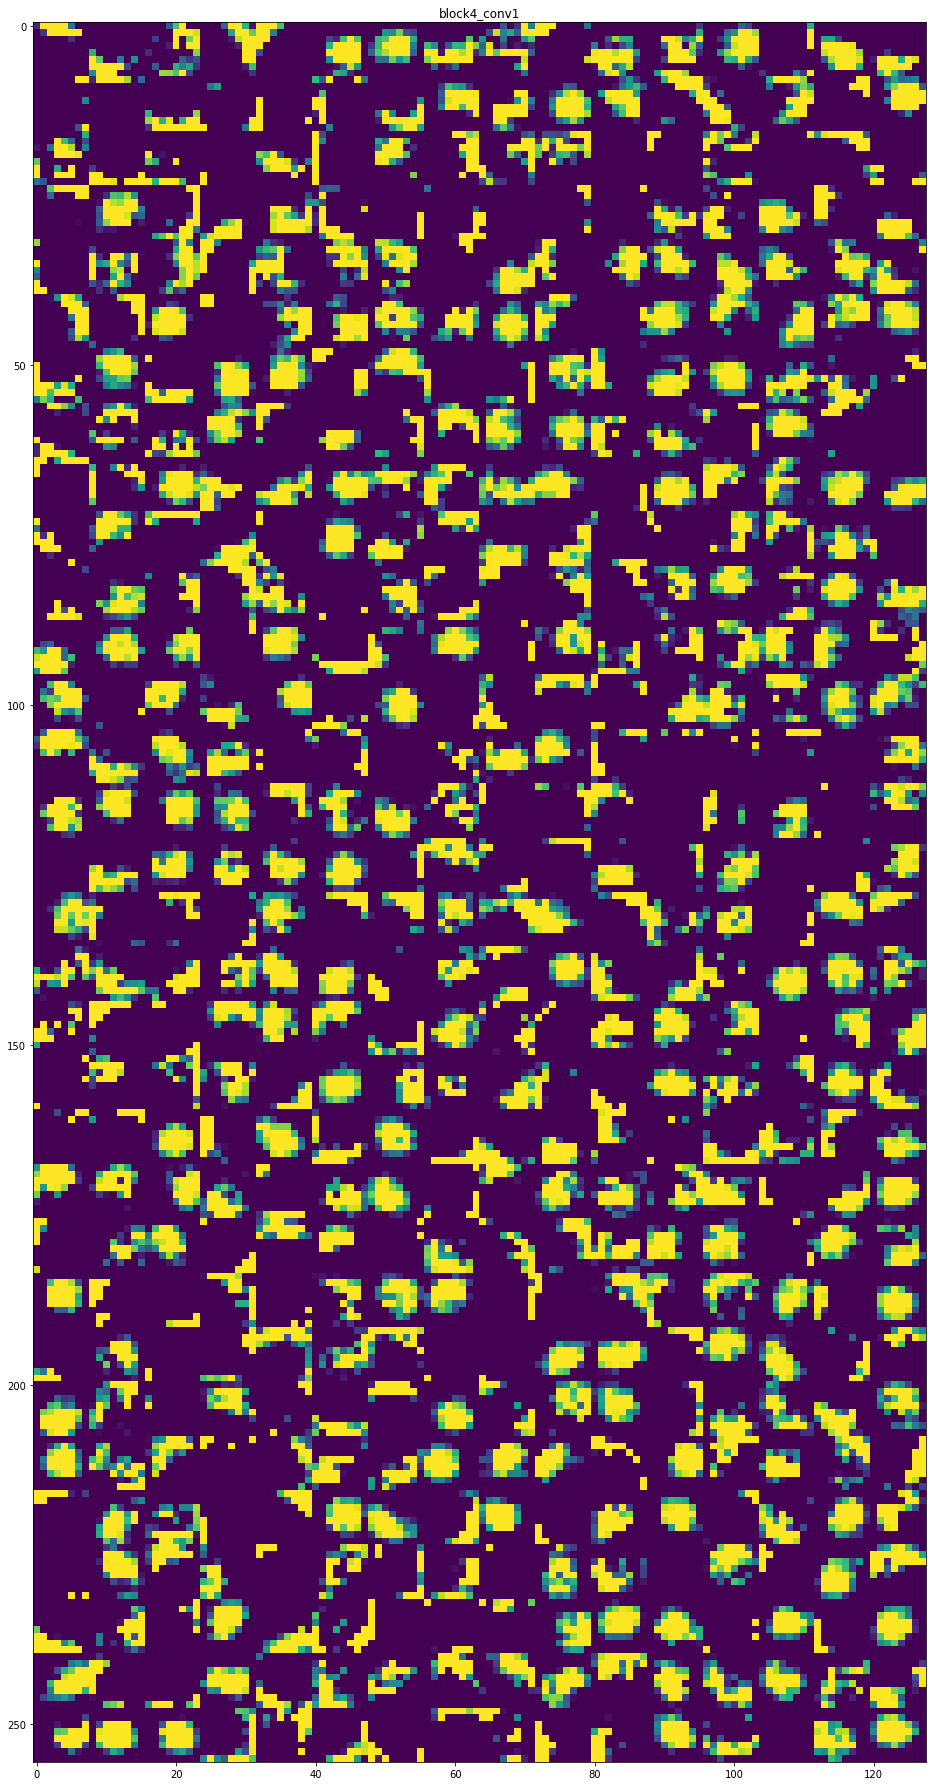

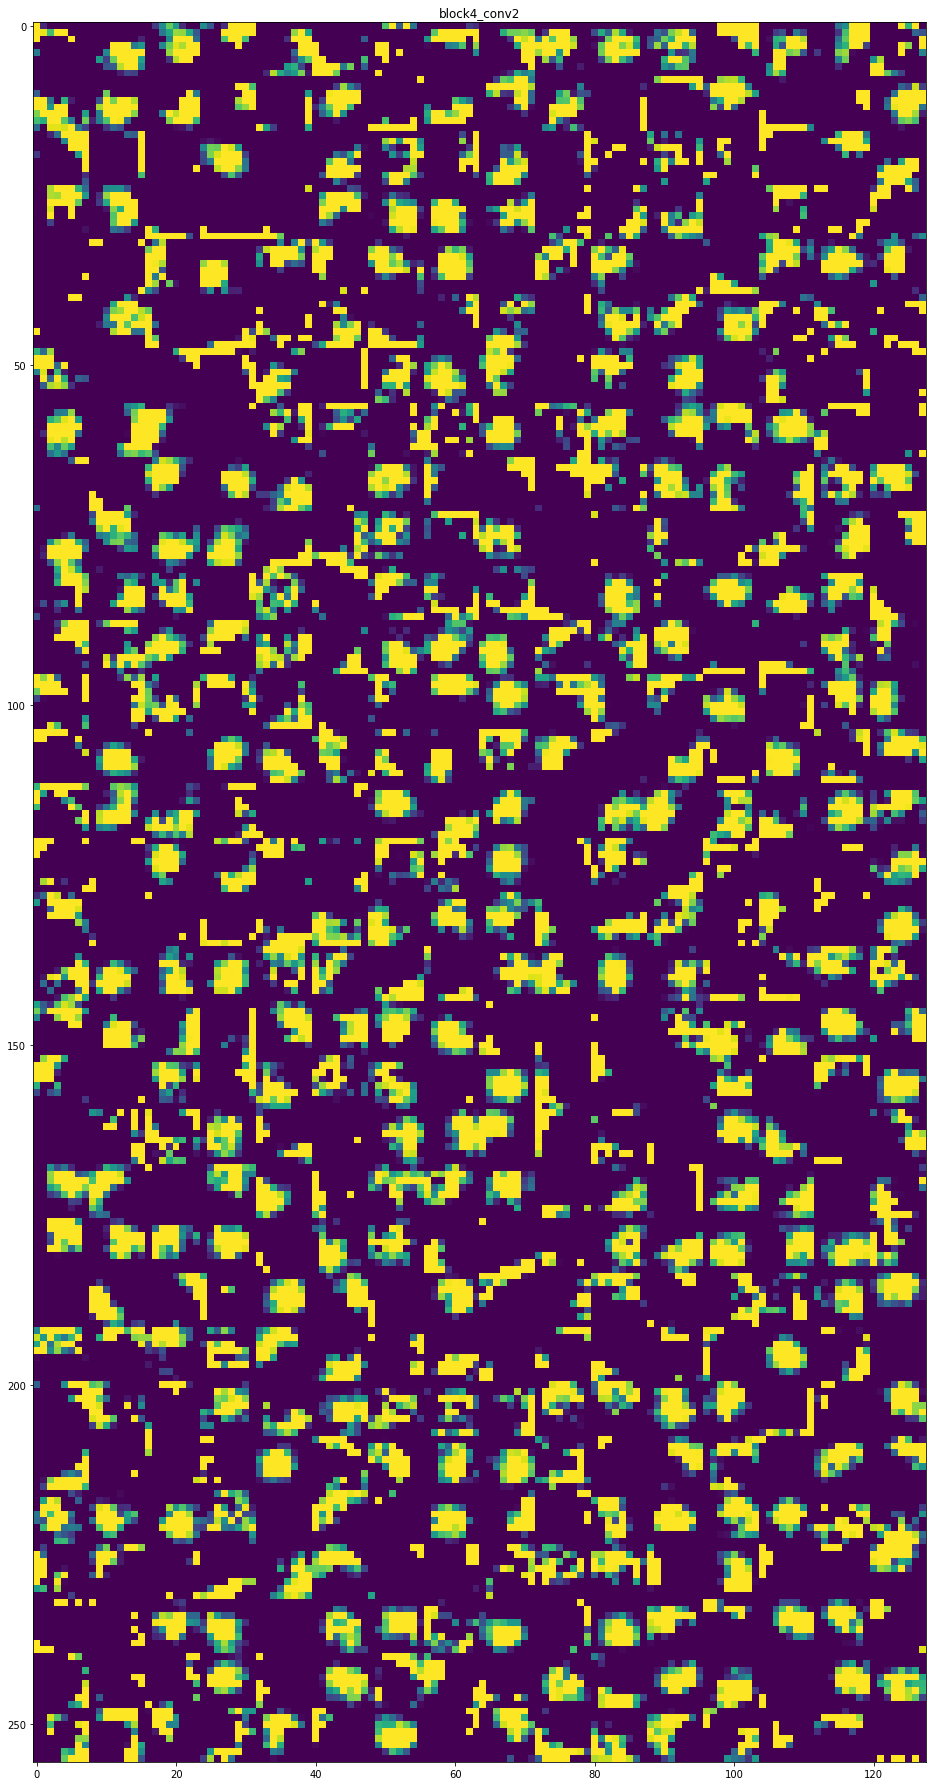

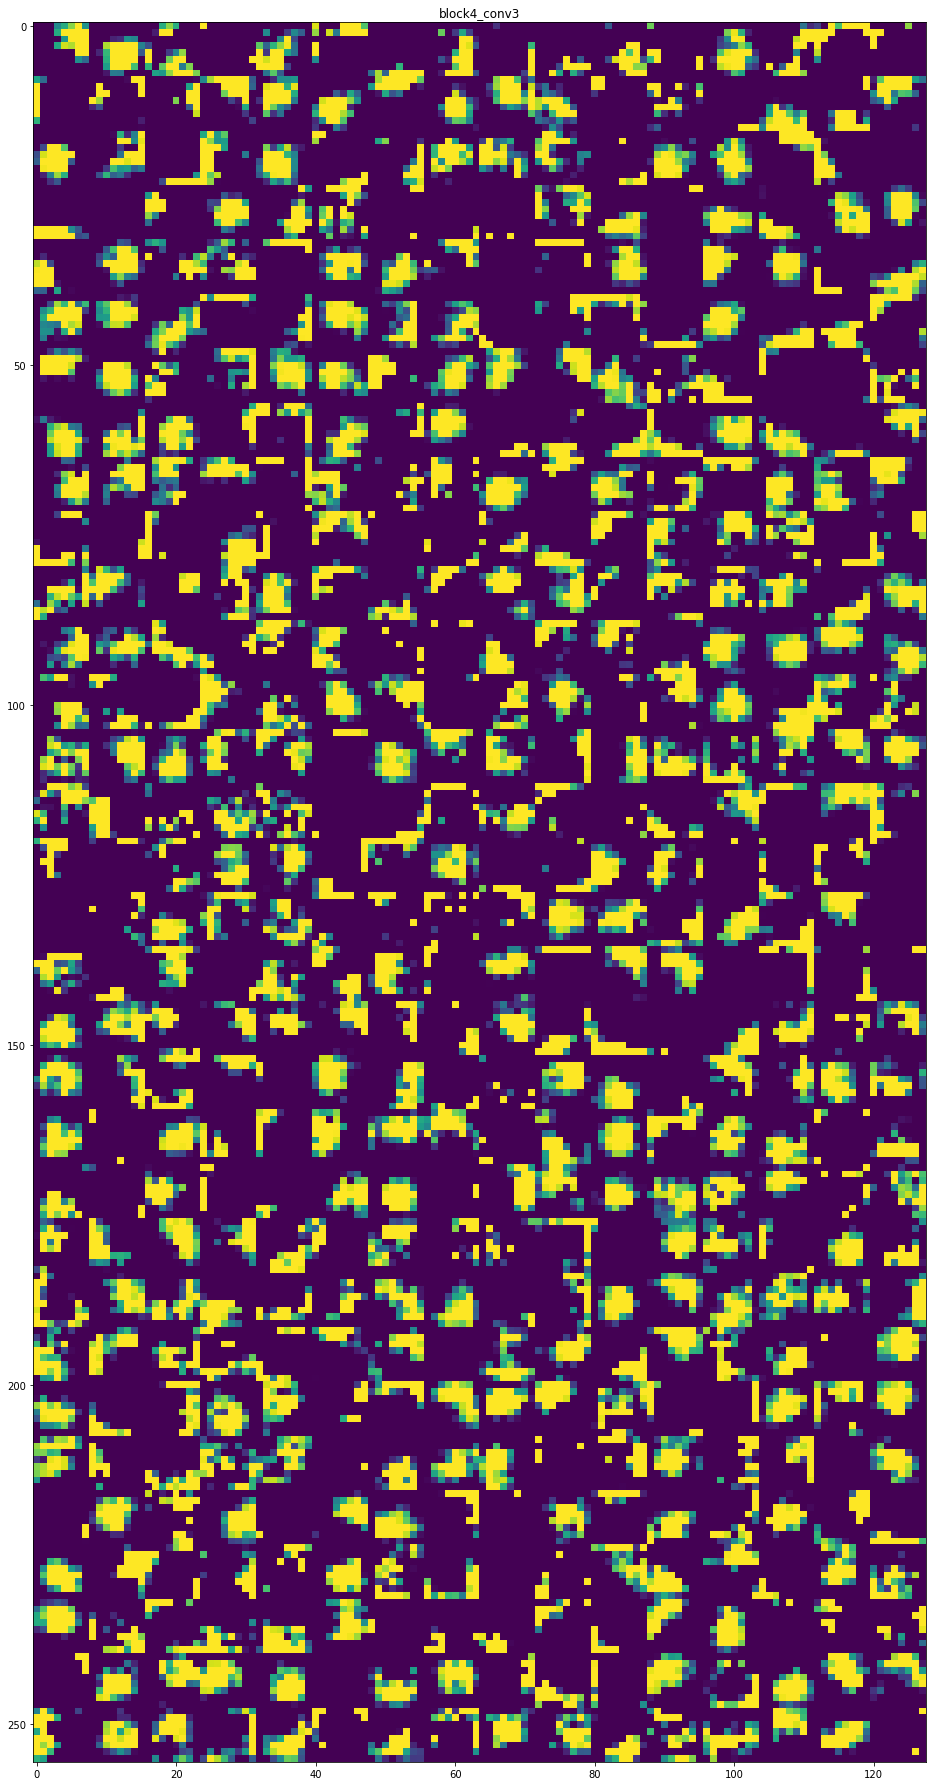

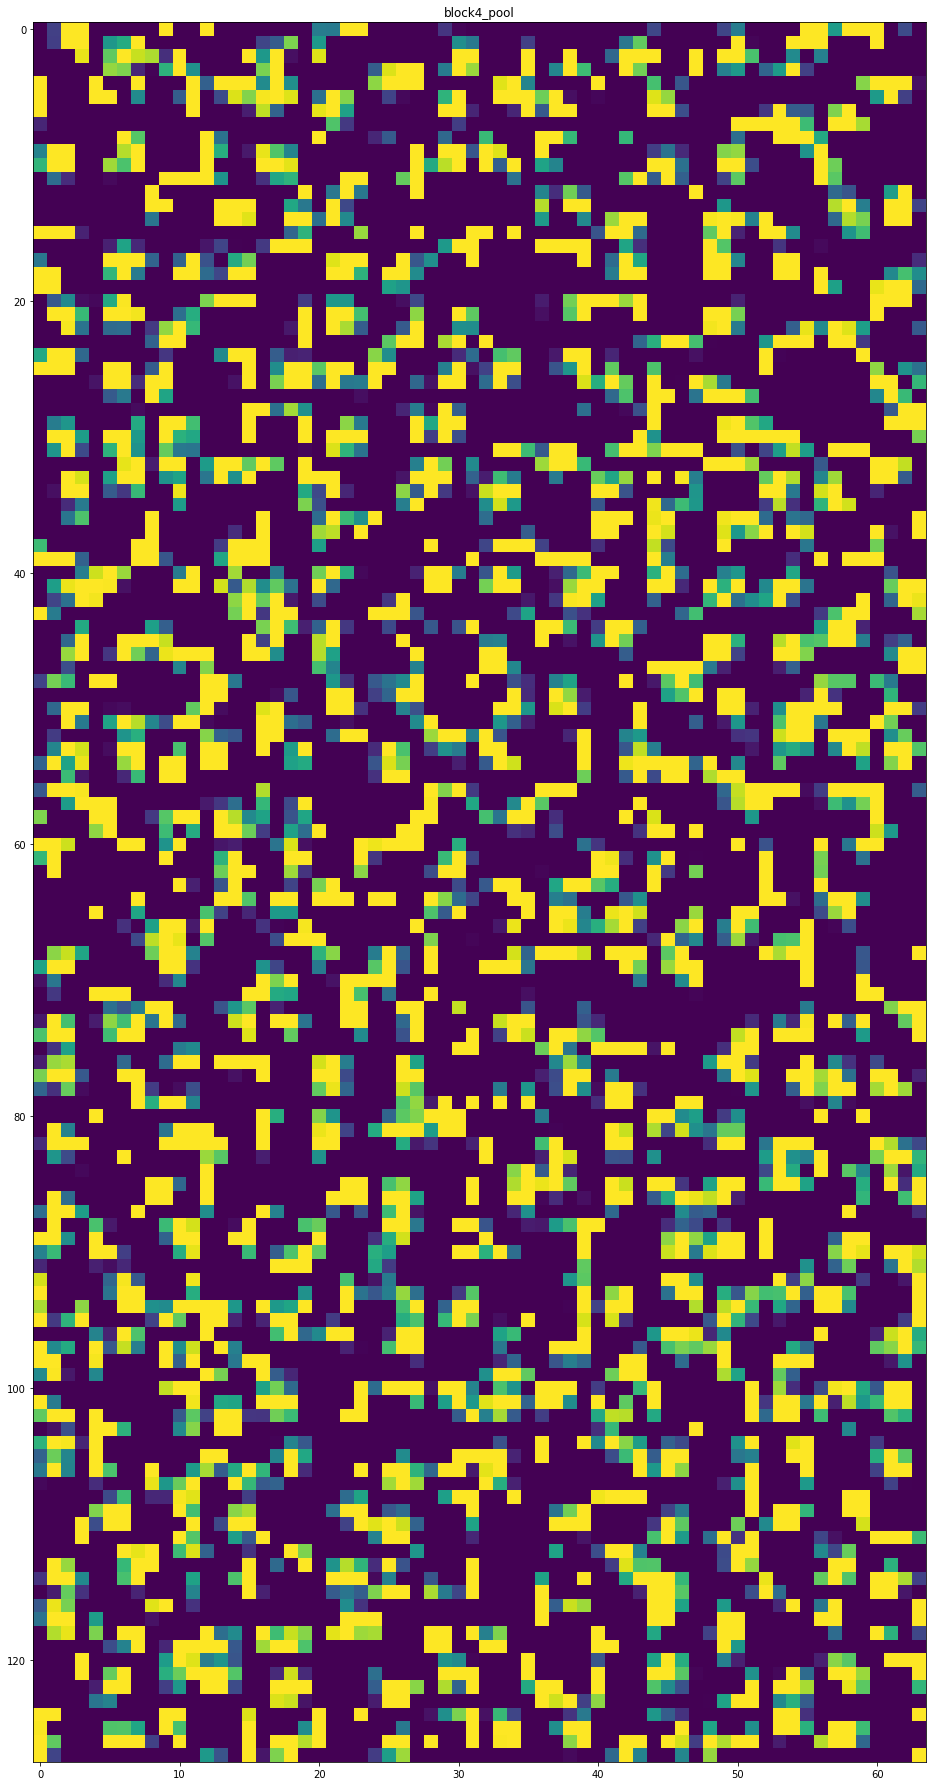

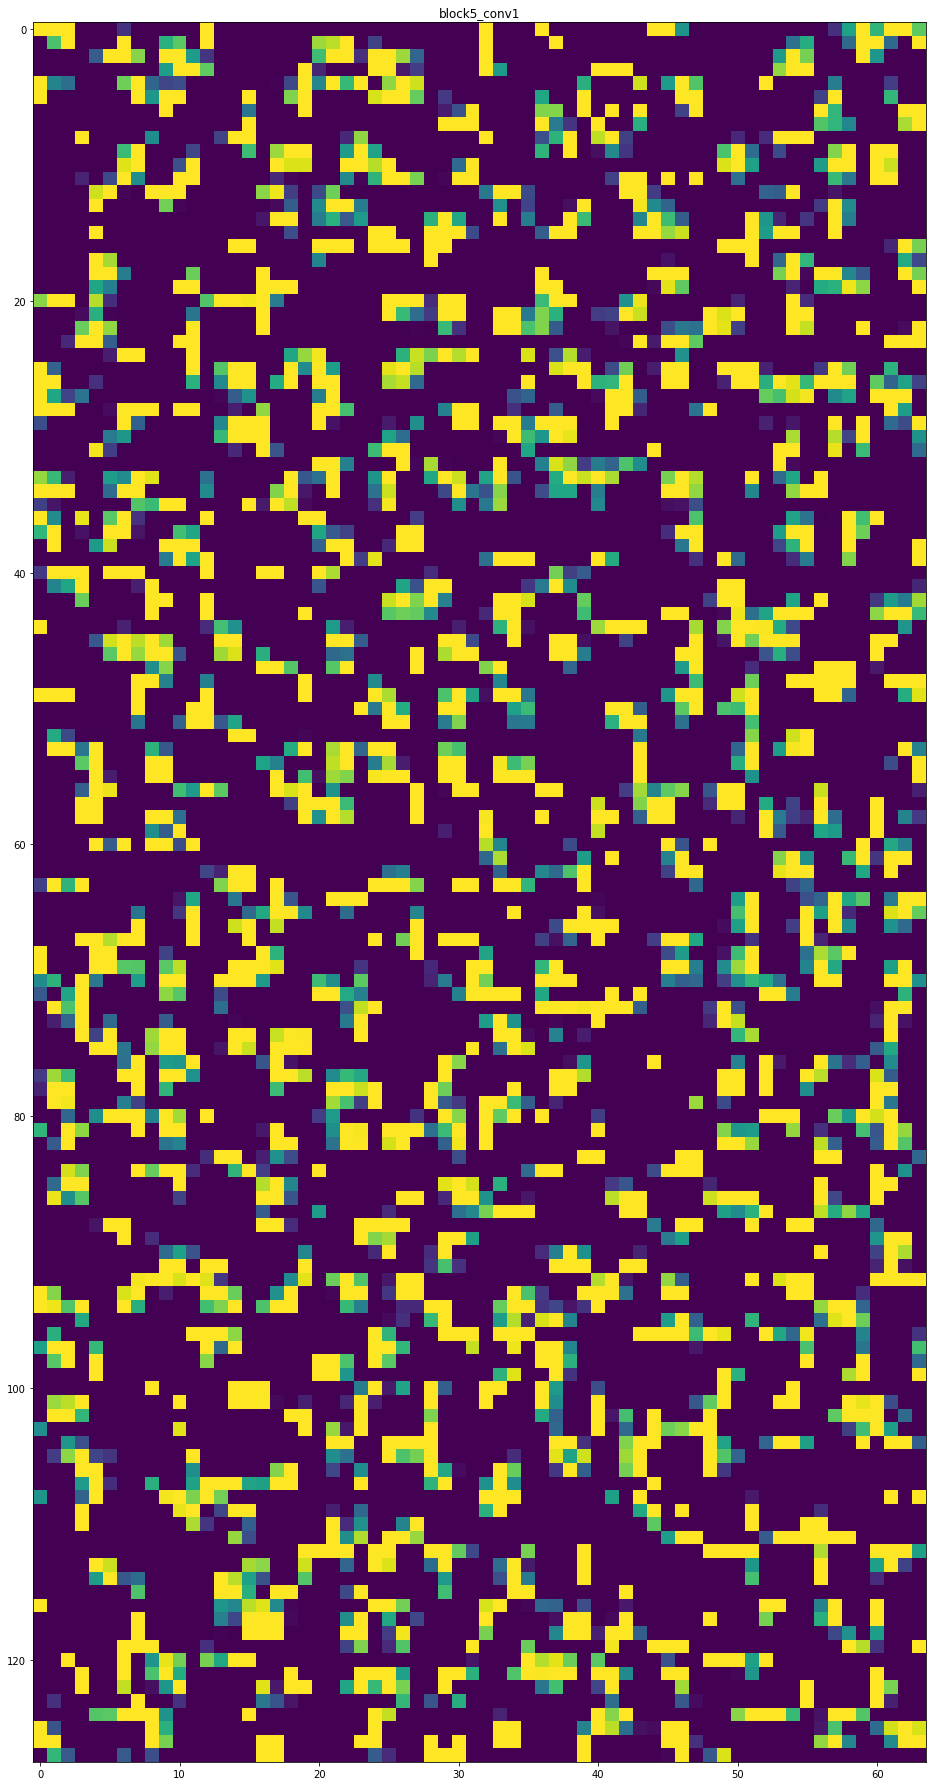

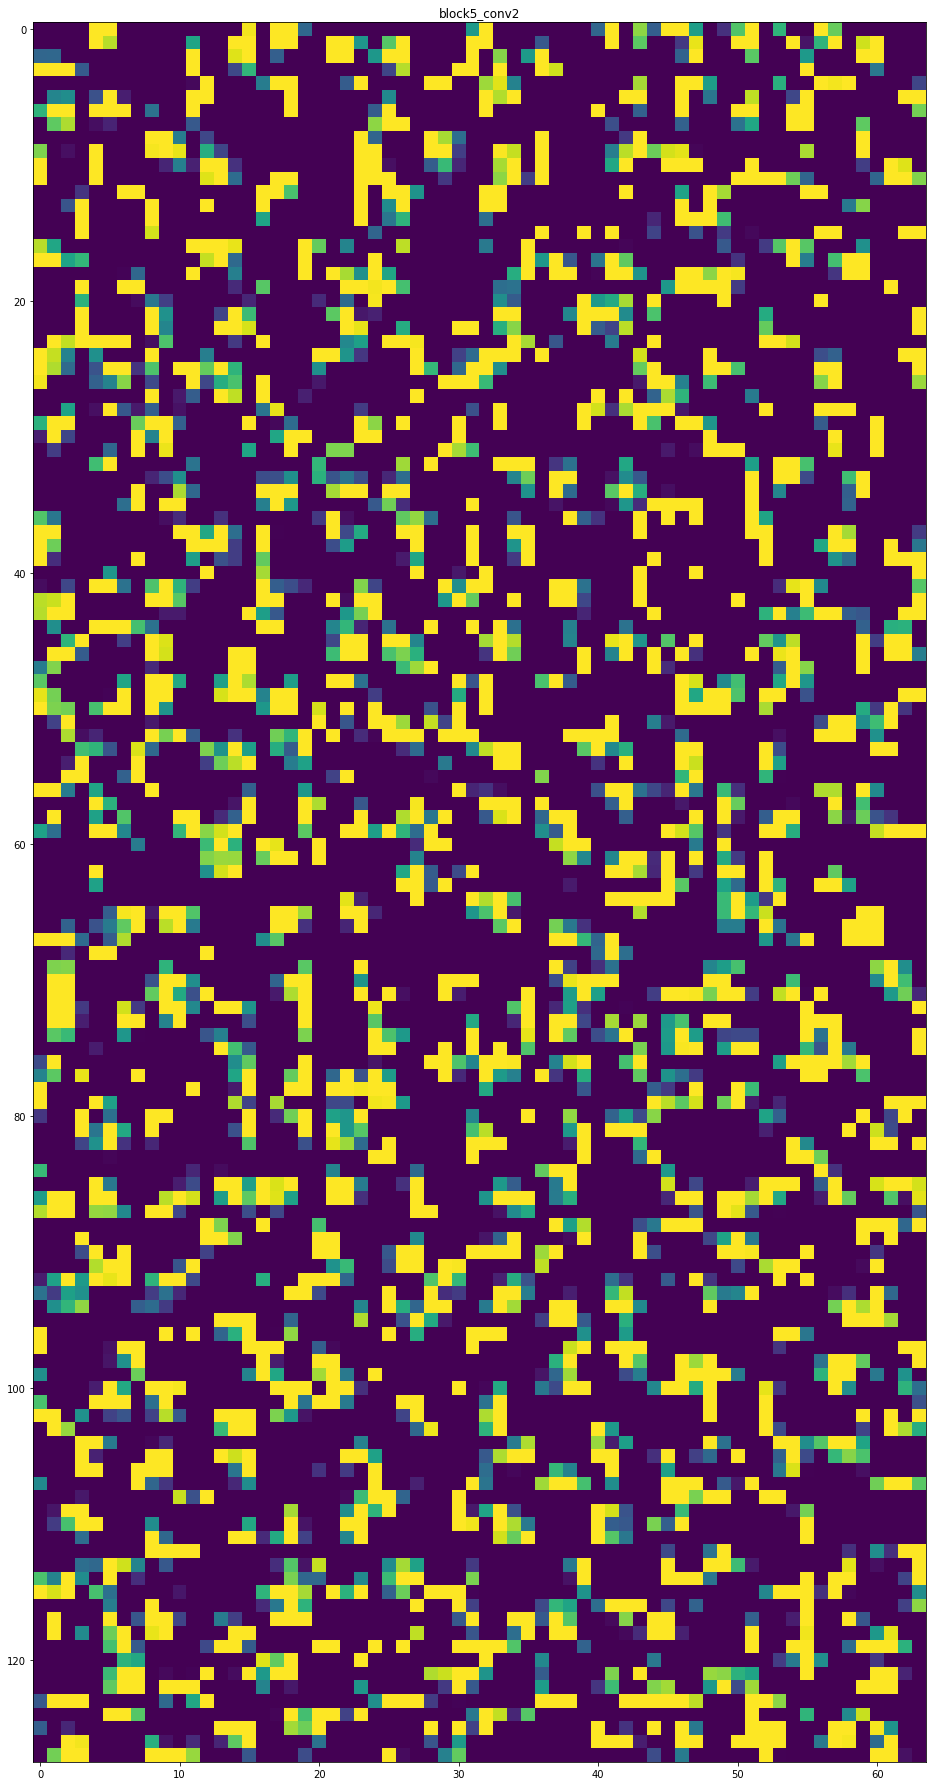

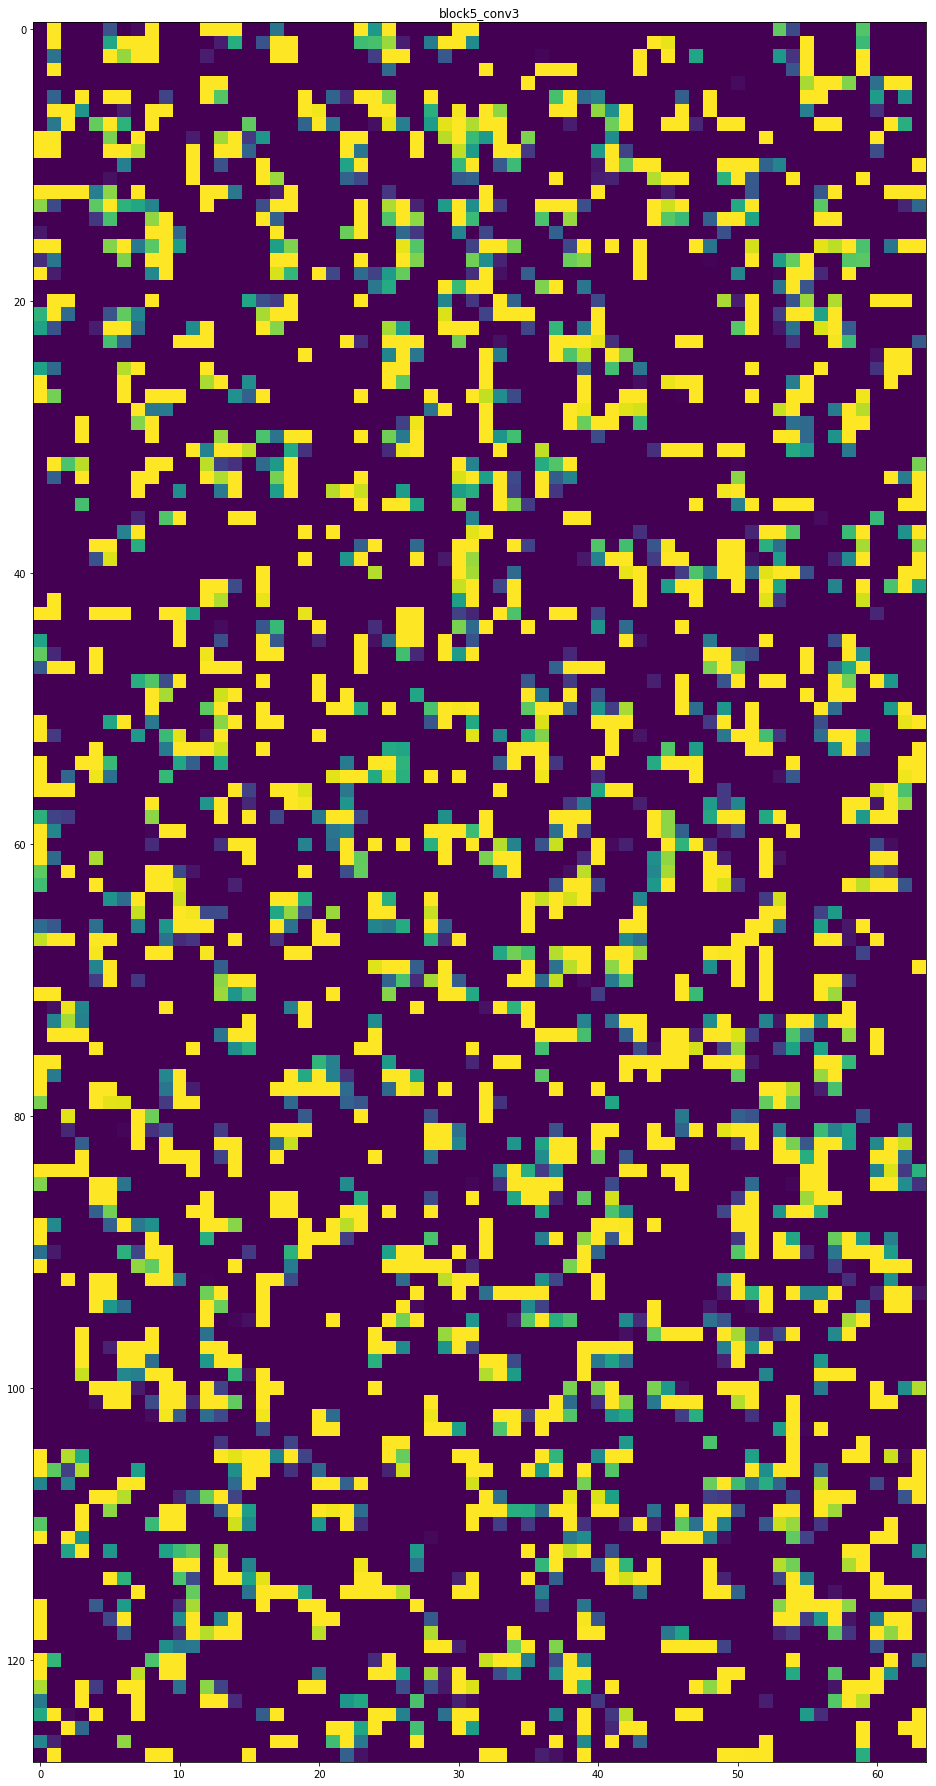

In [18]:
activations = show_random_sample(idx=1)
visualize_intermediate_activations(activations=activations, 
                                   layer_names=layer_names)